In [1]:
"""Data inspection."""

'Data inspection.'

In [25]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)
import toylosses
importlib.reload(toylosses)

NEURO_DIR = '/neuro/'

IMG_SHAPE = (25, 25)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
train_dataset, val_dataset = datasets.get_dataset_connectomes(img_shape=IMG_SHAPE)

TRAIN_IMG_PATH = '/neuro/train_val_datasets/train_conn_%s.npy' % SHAPE_STR
OUTPUT = '/scratch/users/nmiolane/output_connectomes'
CMAP = 'Spectral'



Loading /neuro/train_val_datasets/train_conn_25x25.npy...
Loading /neuro/train_val_datasets/val_conn_25x25.npy...


In [33]:
import geomstats
from geomstats.spd_matrices_space import SPDMatricesSpace

os.environ['GEOMSTATS_BACKEND'] = 'numpy'
spd = SPDMatricesSpace(n=2)
a = spd.random_uniform()
a_vec = spd.vector_from_symmetric_matrix(a)
a_mat = spd.symmetric_matrix_from_vector(a_vec)
print(a)
print(a_mat)

AttributeError: module 'geomstats.backend' has no attribute 'tril_indices'

In [29]:
import geomstats
from geomstats.general_linear_group import GeneralLinearGroup

def is_spd(x):
    if x.ndim == 2:
        x = np.expand_dims(x, 0)
    _, n, _ = x.shape
    gln_group = GeneralLinearGroup(n=n)
    for one_mat in x:
        assert is_pos_def(one_mat)
        assert gln_group.belongs(one_mat)

is_spd(train_dataset[:, 0, :, :])


AssertionError: 

From: https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

1. netmats1: Using "full" normalized temporal correlation between every node timeseries
and every other. This is a common approach and is very simple, but it has various
practical and interpretational disadvantages [Smith 2012].
2. netmats2: Using partial temporal correlation between nodes' timeseries. This aims to
estimate direct connection strengths better than achieved by full correlation. To slightly
improve the estimates of partial correlation coefficients, a small amount of L2
regularization is applied (setting rho=0.01 in the Ridge Regression netmats option in
FSLNets) [Smith OHBM 2014, FSLNets]. 

In [11]:
print(train_dataset.shape)
print(np.min(train_dataset))
print(np.max(train_dataset))

(649, 1, 25, 25)
-24.786836311803345
57.00069731630089


In [20]:
from geomstats.general_linear_group import GeneralLinearGroup
from geomstats.matrices_space import MatricesSpace
from geomstats.spd_matrices_space import SPDMatricesSpace

gln = GeneralLinearGroup(n=IMG_SHAPE[0])
mat_space = MatricesSpace(n=IMG_SHAPE[0], m=IMG_SHAPE[0])
spd_space = SPDMatricesSpace(n=IMG_SHAPE[0])
assert gln.belongs(train_dataset[:, 0, :, :]).all()
assert mat_space.is_symmetric(train_dataset[:, 0, :, :]).all()

In [17]:
def r_from_z(mat):
    dim, _ = mat.shape
    r_mat = np.zeros_like(mat)
    for i in range(dim):
        for j in range(dim):
            r_mat[i, j] = np.dot(mat[i, :], mat[j, :]) / (dim - 1)
    return r_mat

In [23]:
toylosses.is_spd(train_dataset[:, 0, :, :])

one_conn = train_dataset[4][0]
print(np.linalg.det(one_conn))


def laplacian(a):
    d = np.diag(np.array(a.sum(1)).flatten())
    return d-a

print(np.diag(one_conn)) 
one_conn_r = one_conn #r_from_z(one_conn)
one_conn2 = laplacian(one_conn_r) + np.eye(IMG_SHAPE[0])

assert gln.belongs(np.abs(one_conn_r))
assert mat_space.is_symmetric(one_conn_r)

assert is_pos_def(one_conn_r)

eig, vec = np.linalg.eig(one_conn_r)
print(eig)

print(np.min(one_conn_r))
print(np.max(one_conn_r))

dist = spd_space.metric.dist(train_dataset[4][0], train_dataset[1][0])
print(dist)

4.1347417857952906e+18
[14.66533078 23.69358162 18.5009287  20.97197158 18.22327386 17.33912605
 17.8314678  12.22317422  9.8453935  15.95084759 19.90724511 12.66488278
 18.07738441  7.06788835 11.72378836 15.87685508 15.63567894 11.72559451
  8.3605313  14.09783447  8.12462889 12.36122579 11.48487559  2.81153679
  5.25463302]
[5.40412208e+01 4.21237748e+01 3.20069582e+01 2.76611845e+01
 2.64130559e+01 2.46731590e+01 2.28648173e+01 2.02196920e+01
 1.98184228e+01 1.22887410e+01 1.06603289e+01 9.72025202e+00
 9.25418831e+00 8.36826429e+00 5.49981528e+00 5.07462318e+00
 4.24134083e+00 2.82248169e+00 2.37736102e+00 3.09632236e-02
 2.04510981e-01 4.27825890e-01 8.26299848e-01 1.43251550e+00
 1.36788177e+00]
-6.8159285125833335
23.693581622766665
point
(25, 25)
base_point
(25, 25)
sqrt_base_point
(1, 25, 25)
sqrt_base_point
[[[ 3.28417897e+00  1.04987073e+00 -2.90627583e-01 -9.54119885e-02
    7.72082361e-01 -8.39788789e-02  3.84953359e-01 -1.57587898e-01
   -2.18935561e-01 -7.24430858e-01  

In [40]:
train, val = datasets.get_loaders('connectomes_schizophrenia', img_shape=(28, 28), batch_size=8)

In [49]:


i = 0
for train_batch in train:
    if i > 2:
        break
    one_c = train_batch[0].cpu().to_numpy()
    print(one_c.diag())
    #print(one_c)
    assert gln.belongs(np.abs(one_c))
    assert mat_space.is_symmetric(one_c)
    
    hat_l1 = laplacian(g) + GAMMA * np.eye(N_NODES)
    
    eig, vec = np.linalg.eig(np.abs(one_c))
    print(eig)
    assert is_pos_def(one_c)
    
    i += 1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
[14.140245    2.6287587   0.9954727   0.4659352   0.2830725   0.06016125
 -0.14924623 -0.36064997 -1.3436807  -0.46716827 -0.5940811  -1.1762954
 -0.6605288  -0.6902532  -0.79580665 -0.814593   -1.0677731  -0.8527636
 -1.0187019  -0.9057516  -0.9160467  -0.92949617 -0.94423336 -0.99597937
 -0.95625234 -0.9690076  -0.98612094 -0.9792158 ]


AssertionError: 

In [3]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

Loading /neuro/train_val_datasets/train_conn_100x100.npy
Dataset shape: (649, 1, 100, 100)


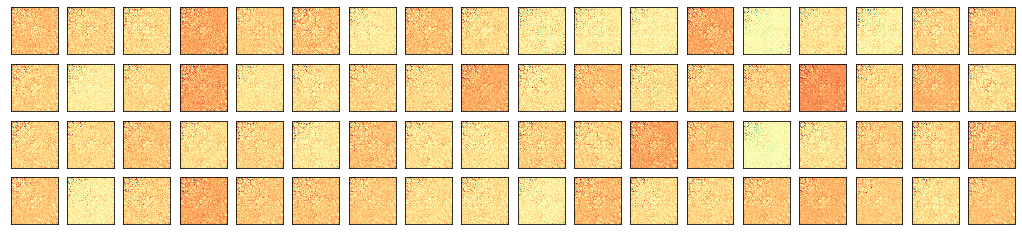

In [3]:
vis.show_data(TRAIN_IMG_PATH, cmap=CMAP)

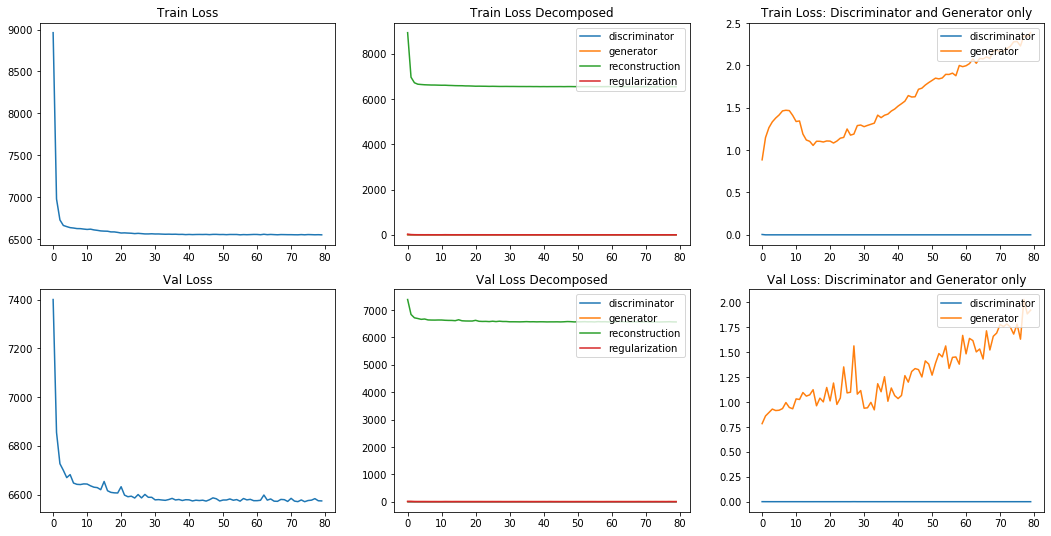

In [22]:
epoch_id = 79
vis.plot_losses(OUTPUT, epoch_id=epoch_id)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


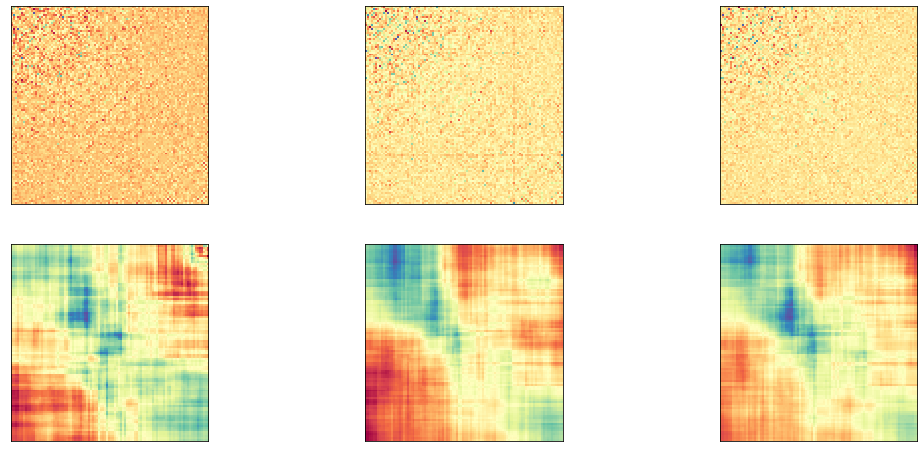

In [6]:
epoch_id = 1
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


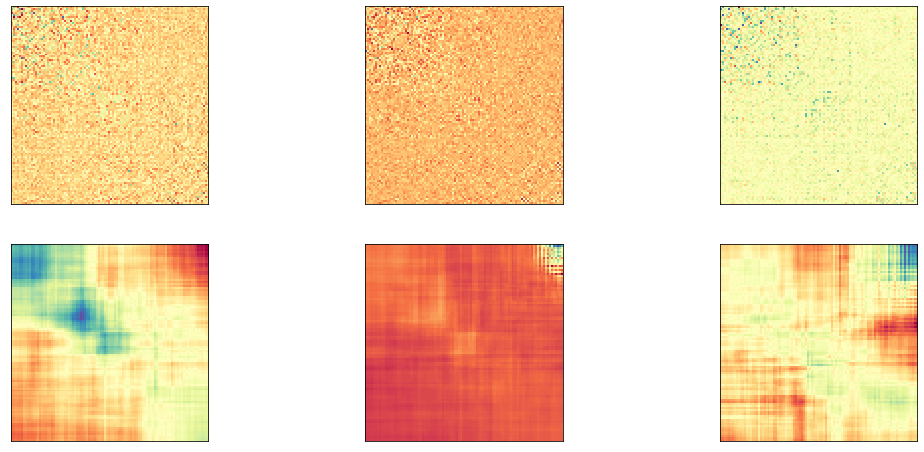

In [7]:
epoch_id = 2
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


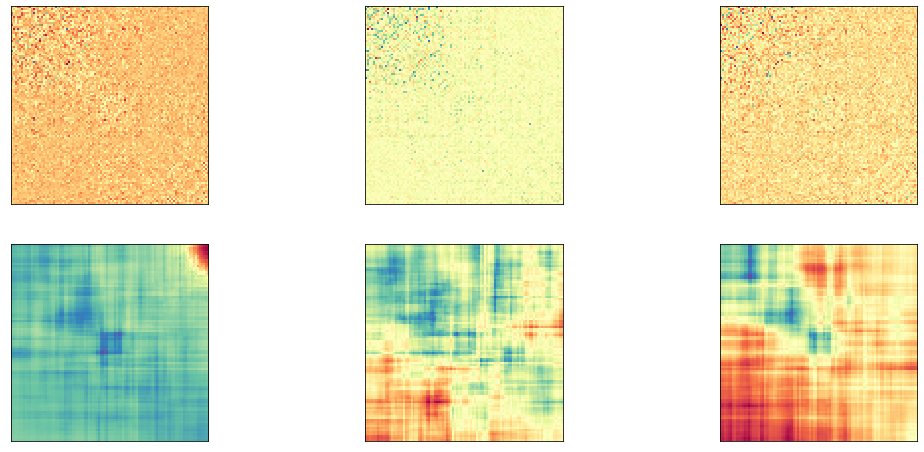

In [8]:
epoch_id = 5
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


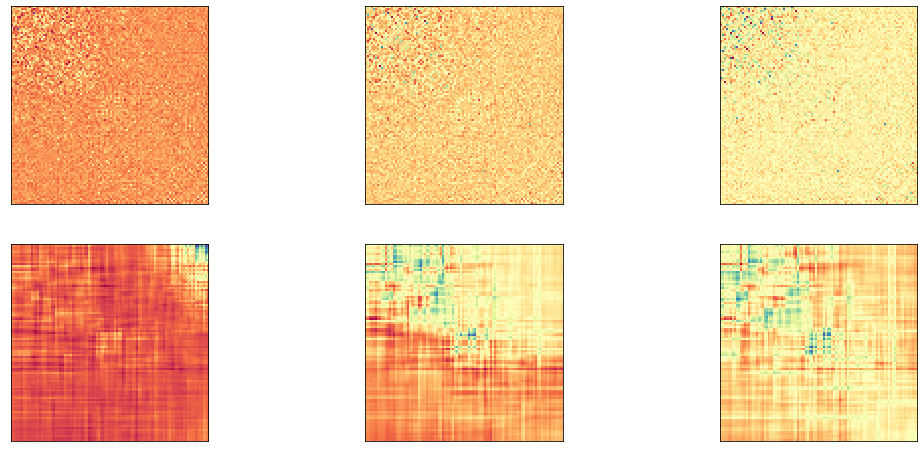

In [9]:
epoch_id = 10
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


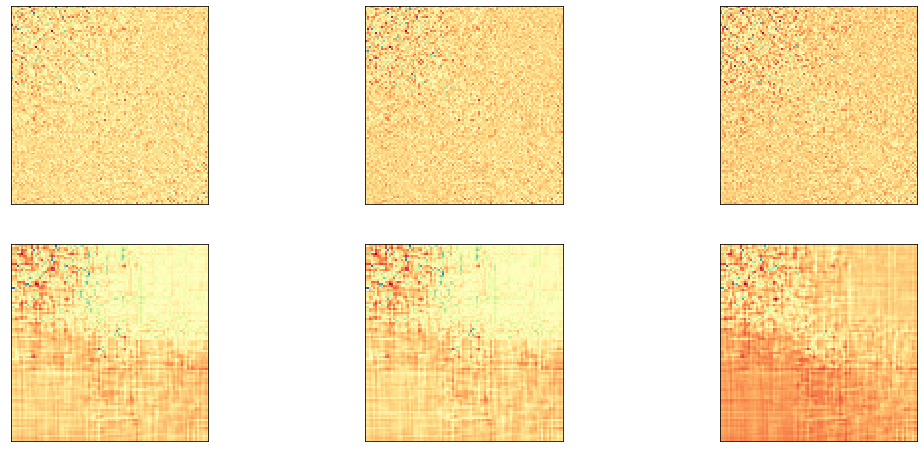

In [10]:
epoch_id = 15
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


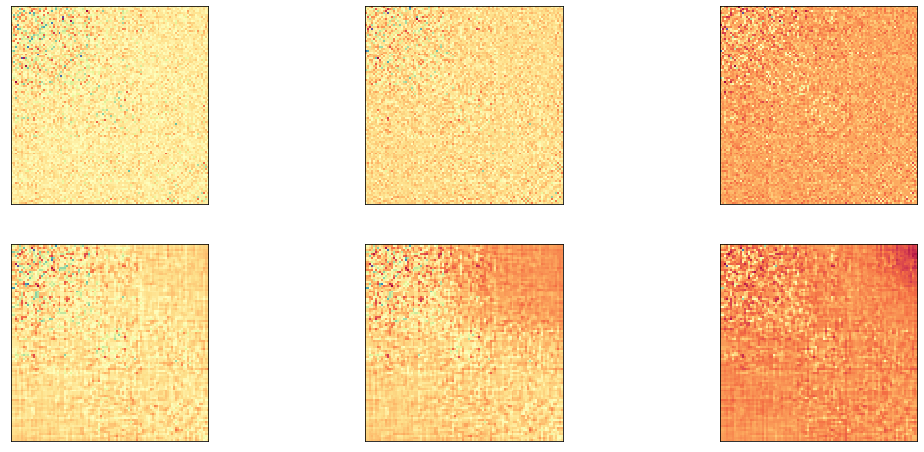

In [11]:
epoch_id = 20
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Shape of img data:
(3, 1, 100, 100)
Shape of recon:
(3, 1, 100, 100)


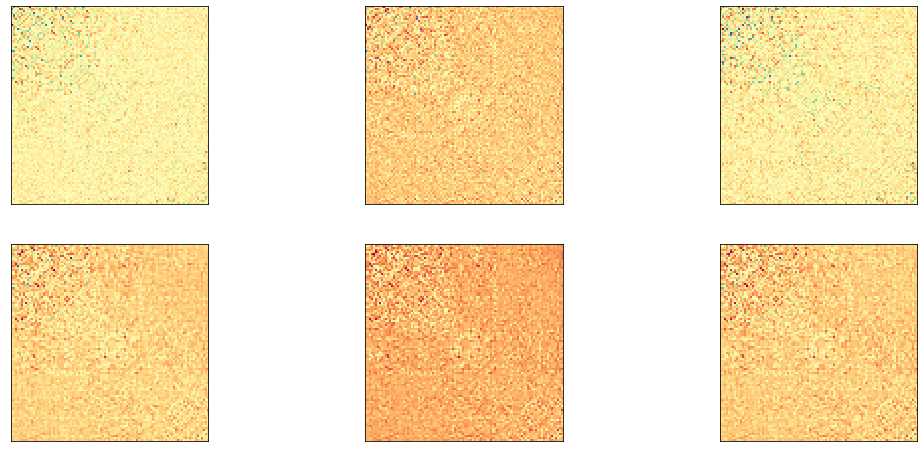

In [26]:
epoch_id = 30
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap=CMAP)

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_1_encoder_train_loss_6977.0121_val_loss_6854.9594.pth


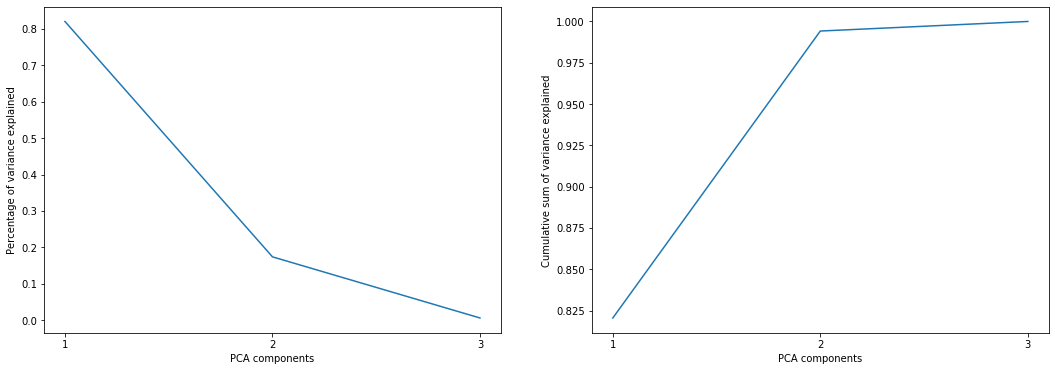

In [13]:
epoch_id = 1
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_10_encoder_train_loss_6613.7961_val_loss_6643.0544.pth


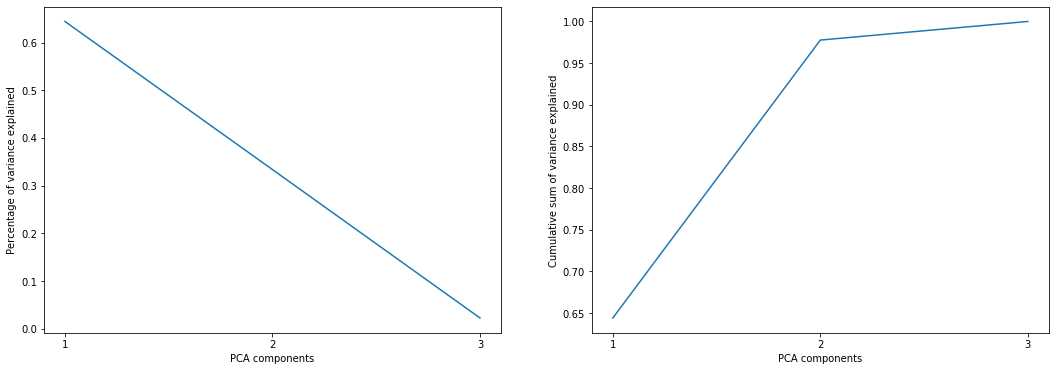

In [14]:
epoch_id = 10
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_20_encoder_train_loss_6571.0562_val_loss_6632.0458.pth


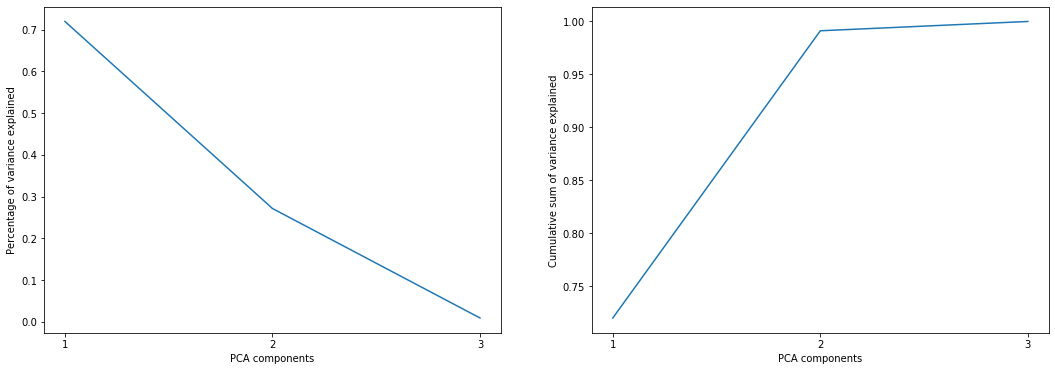

In [15]:
epoch_id = 20
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_30_encoder_train_loss_6559.3464_val_loss_6578.0844.pth


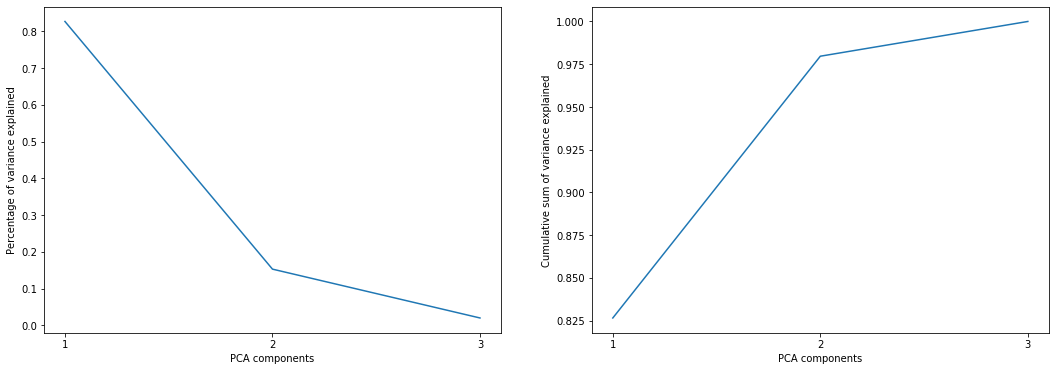

In [24]:
epoch_id = 30
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=epoch_id)

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_30_encoder_train_loss_6559.3464_val_loss_6578.0844.pth


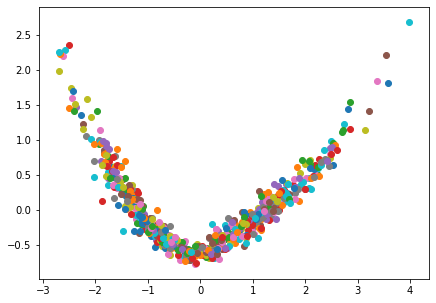

In [25]:
epoch_id = 30
n_pcs = 2
dataset = np.load(TRAIN_IMG_PATH)

mus = analyze.latent_projection(OUTPUT, dataset, epoch_id=epoch_id)
_, projected_mus = analyze.pca_projection(mus, n_pcs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

for mu in projected_mus:
    if n_pcs == 2:
        im = ax.scatter(mu[0], mu[1]) 
    else:
        im = ax.scatter(mu[0], mu[1], mu[2])

Loading: /scratch/users/nmiolane/output_connectomes/training/models/epoch_50_encoder_train_loss_6553.4051_val_loss_6577.4475.pth


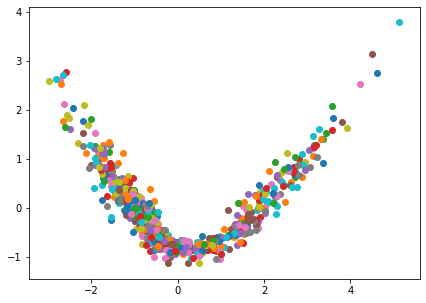

In [23]:
epoch_id = 50
n_pcs = 2
dataset = np.load(TRAIN_IMG_PATH)

mus = analyze.latent_projection(OUTPUT, dataset, epoch_id=epoch_id)
_, projected_mus = analyze.pca_projection(mus, n_pcs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

for mu in projected_mus:
    if n_pcs == 2:
        im = ax.scatter(mu[0], mu[1]) 
    else:
        im = ax.scatter(mu[0], mu[1], mu[2])